In [11]:
using Revise
includet("./base.jl")
using StatsBase

In [12]:
using CairoMakie

# No-space

In [154]:
N = 100
logKs = range(-0.5, 5, N)
lis = range(0., 1., N)
@time xx = run_explike_Kl_nospace(logKs, lis, 10000000;
    save_sols=true
)
countmap(xx[1])

  4.292490 seconds (9.09 M allocations: 714.888 MiB, 8.27% gc time, 18.44% compilation time)


Dict{SciMLBase.ReturnCode.T, Int64} with 1 entry:
  Success => 10000

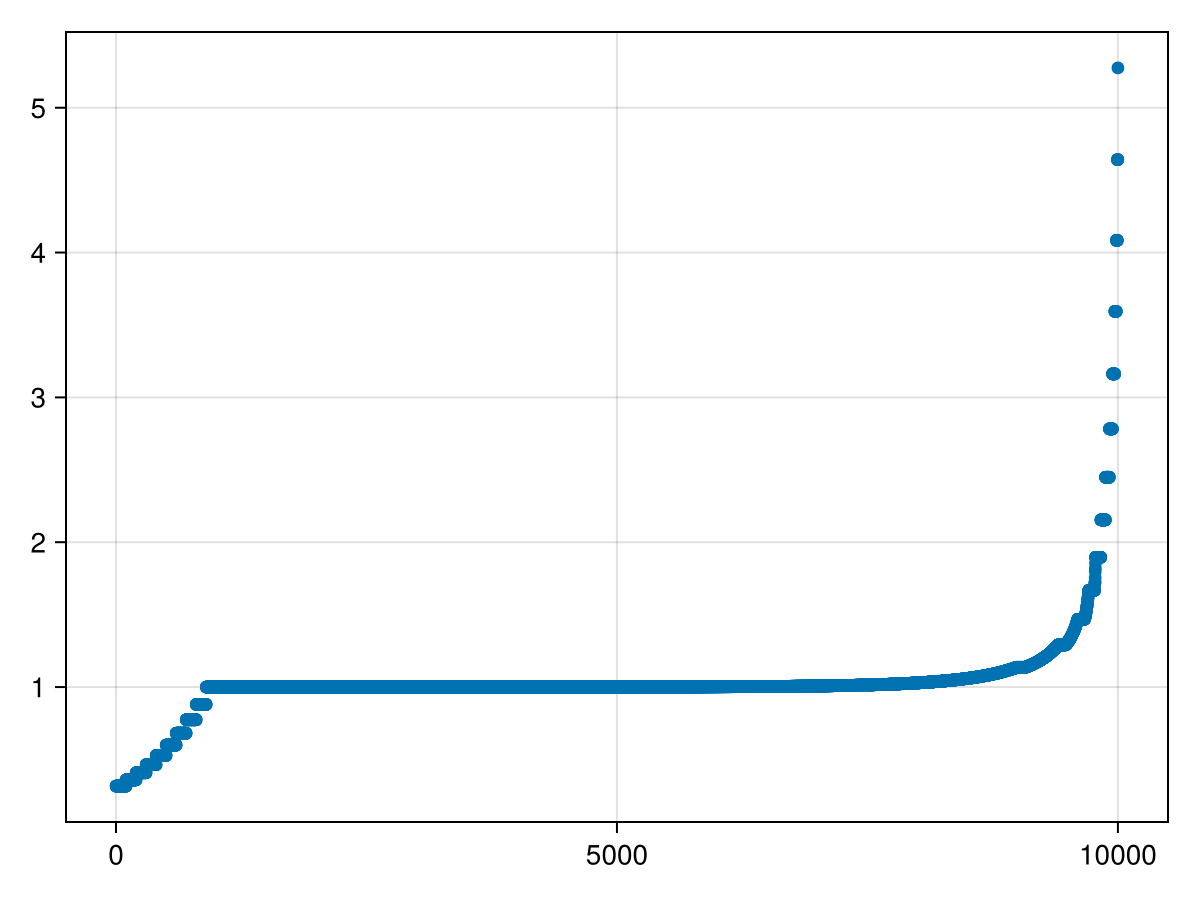

In [177]:
yy = getindex.(xx.final_states, 2)
scatter(sort(yy[:]))

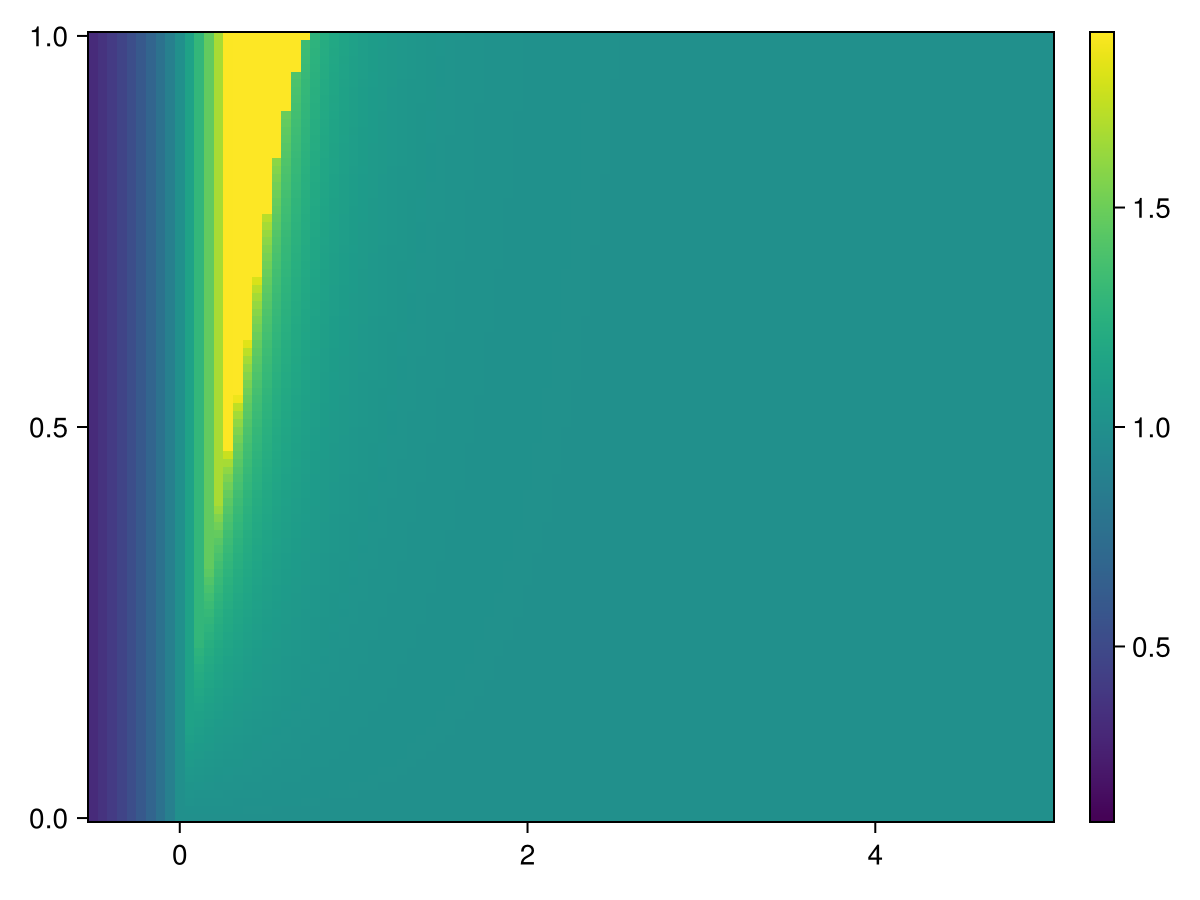

In [188]:
yy = getindex.(xx.final_states, 2)
fap = heatmap(logKs, lis, clamp.(yy, max(minimum(abs, yy), eps()), Inf);
    # colorscale=log10
    colorrange=(1., 1.) .+ (-1., 1.) .* 0.9
)
Colorbar(fap.figure[1,2], fap.plot)
fap

# Space

In [31]:
N = 2
logKs = range(-0.5, 5, N)
lis = range(0., 1., N)
@time xx = run_explike_Kl_space(logKs, lis, 1000;
    solver=QNDF(),
    save_sols=true,
)
countmap(xx.retcodes)

 75.236273 seconds (2.44 M allocations: 6.562 GiB, 86.81% gc time, 0.25% compilation time)


Dict{SciMLBase.ReturnCode.T, Int64} with 1 entry:
  Success => 4

In [30]:
countmap(xx.retcodes)

Dict{SciMLBase.ReturnCode.T, Int64} with 1 entry:
  Success => 4

## Testing

In [189]:
N = 100
logKs = range(-0.5, 5, N)
lis = range(0., 1., N)
@time xx = run_explike_Kl_nospace(logKs, lis, 10000000;
    save_sols=true
)
countmap(xx[1])

  3.646430 seconds (8.92 M allocations: 703.548 MiB, 1.64% gc time)


Dict{SciMLBase.ReturnCode.T, Int64} with 1 entry:
  Success => 10000

In [243]:
s = xx.sols[50,50];
s.u[end]

3-element Vector{Float64}:
 165.31362815996357
   1.0029839480997134
   0.4934416119426851

In [296]:
L = 2
sN = 10000
epsilon = 1e-5
dx = L / (sN + 1)

mmp = MMParams(;
    m=1.,
    K=10.,
    c=1.,
    d=1.,
    l=1.,
)
sps = SASMMiCRMParams(
    mmp_to_mmicrm(mmp),
    SA[1e-12, 1., 1.], 
    make_cartesianspace_smart(1; dx),
    nthreads()
)
u0 = reduce(hcat, [[1., 0., 0.] .+ epsilon .* randn(3) for _ in 1:sN])
sp = make_smmicrm_problem(sps, u0, 10000)

@time ss = solve(sp, TRBDF2());

  4.147894 seconds (320.91 k allocations: 3.489 GiB, 1.83% gc time)


In [310]:
sum(ss.u[end]; dims=2)[:,1]

3-element Vector{Float64}:
 77174.34089890757
 13023.18731739632
  9802.471783694742

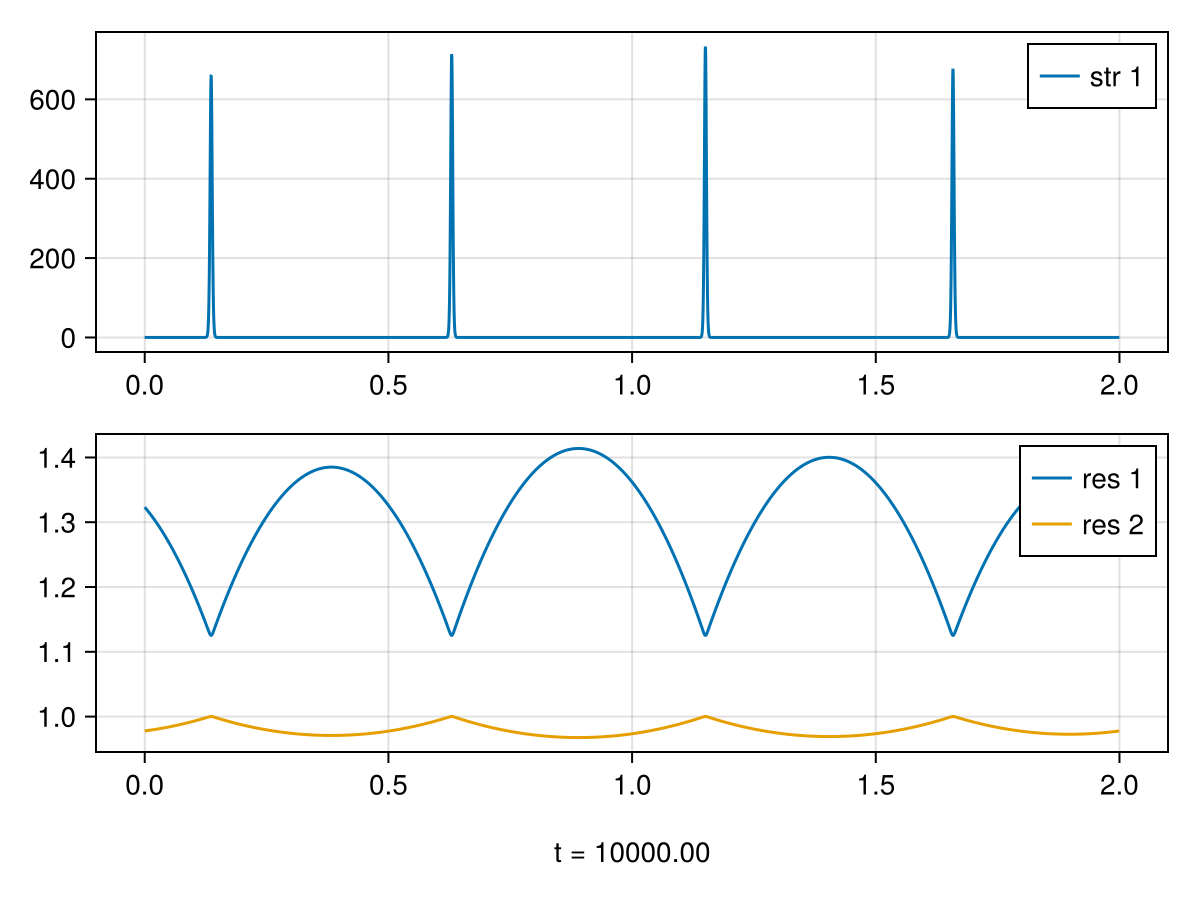

In [311]:
plot_1dsmmicrm_sol_snap(ss, -1)